In [1]:
# necessary packages #

#using Pkg
#Pkg.add("Distances")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
#using NearestNeighbors # Can't use KDtree in julia for posterior prediction

In [2]:
include("../../util.j")

colnorm (generic function with 1 method)

In [3]:
# unnecessary packages #

#using Pkg
#Pkg.add("UnicodePlots")
using UnicodePlots   # check the structure of the sparse matrix
using BenchmarkTools

using StatsPlots
using MCMCChains
using PrettyTables

In [4]:
#using Pkg
#Pkg.add("NearestNeighborDescent");
#using NearestNeighborDescent

In [5]:
@load "../data/sim1data.jld";

In [6]:
# priors #
μβ = fill(0.0, p, q); inv_Vr = [[0.0 0.0]; [0.0 0.0]]; # set Vr^{-1} be zero for the simulation...
νΣ = q + 1; ΨΣ = [[1.0 0.0]; [0.0 1.0]];
inv_Lr = [[0.0 0.0]; [0.0 0.0]]; Lμβ = inv_Lr * μβ;

In [7]:
# cross-validation Preparison
# (a) Randomly split S into K folder 
Random.seed!(321); #1 11 1234
kf = 5;
parts = kfoldperm(n,kf);

# (b) Build NN index for training data in ith folder
using RCall
CVNN_train = Array{Any,1}(undef, kf);
CVNN_test = Array{Any,1}(undef, kf);
CVnnIndx_col = Array{Any,1}(undef, kf);
CVnnIndx_row = Array{Any,1}(undef, kf);
CVMnnIndxLU = Array{Any,1}(undef, kf); 
CVMnnIndx = Array{Any,1}(undef, kf);
@rput coords_ord
@rput S
@rput m
@rput parts

for i in 1:kf
    
    # Build NN index for training data in ith folder
    CVNN_train[i] = BuildNN(coords_ord[:, S[filter(x->!(x in parts[i]), eachindex(S))]], m, 1.0);
    CVnnIndx_col[i] = vcat(CVNN_train[i].nnIndx, 1:(n - length(parts[i])));
    CVnnIndx_row[i] = zeros(Int64, 0);
    for j in 2:m
        CVnnIndx_row[i] = vcat(CVnnIndx_row[i], fill(j, j - 1));
    end
    CVnnIndx_row[i] = vcat(CVnnIndx_row[i], 
        repeat((m + 1):(n - length(parts[i])), inner = m), 1:(n - length(parts[i])));
        
    # Build nearest neighbor index for holdout locations
    @rput i
    R"""
    library("RANN")
    nn_mod_ho <- nn2(t(coords_ord[, S[-parts[[i]]]]), t(coords_ord[, S[parts[[i]]]]), k = m)
    """
    @rget nn_mod_ho
    CVNN_test[i] = nn_mod_ho;
    CVMnnIndxLU[i] = collect(1:m:(length(parts[i]) * m + 1));
    CVMnnIndx[i] = vec(nn_mod_ho[:nn_idx]');  
end   

┌ Warning: Package RCall does not have AxisArrays in its dependencies:
│ - If you have RCall checked out for development and have
│   added AxisArrays as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with RCall
│ Loading AxisArrays into RCall from project dependency, future warnings for RCall are suppressed.
└ @ nothing nothing:840


In [8]:
# (a) grid of candidate value
ϕ_grid = vcat(LinRange(3 / sqrt(2), 3 * 12.5 / sqrt(2), 25))
#LinRange(3 / sqrt(2), 3 * 50 / sqrt(2), 20) #LinRange(3 / sqrt(2), 3 * 100 / sqrt(2), 20);
α_grid = vcat(LinRange(0.8, 0.99, 25)) #LinRange(0.75, 1, 10); #LinRange(0.5, 1, 10);

In [9]:
# For loop
CVRMSPE = fill(0.0, length(ϕ_grid), length(α_grid));
CVPrecond_D = Array{Any,1}(undef, kf);
prog = Progress(kf, 1, "Computing initial pass...", 50)
for i in 1:kf
    CVnIndx = length(CVNN_train[i].nnIndx);
    nk = length(parts[i]);
    CVA = Array{Float64}(undef, CVnIndx); CVD = Array{Float64}(undef, n - nk);
    Index_train = [filter(x->!(x in parts[i]), eachindex(S))][1];
    CVVK = []; CVXstar = []; CVYstar = []; CVμstar = [];
    
    CVAtilde = Array{Float64}(undef, nk * m); CVDtilde = Array{Float64}(undef, nk);
    CVAtildeM = [];
    
    for j in 1:length(ϕ_grid) 
        for k in 1:length(α_grid)
            
            # obtain posterior estimators of beta
            getAD(coords_ord[:, S[Index_train]], 
                CVNN_train[i].nnIndx, CVNN_train[i].nnDist, CVNN_train[i].nnIndxLU, 
                ϕ_grid[j], 0.5, CVA, CVD);
            CVVK = Diagonal(1 ./ sqrt.(CVD)) * (sparse(CVnnIndx_row[i], 
                    CVnnIndx_col[i], vcat(-CVA, ones(n - nk))));
            CVa = sqrt(α_grid[k] / (1 - α_grid[k]));
            CVXstar = sparse(vcat(repeat(1:(n - nk), 3), repeat((n - nk + 1):(n - nk + p), p)), 
                vcat(repeat(1:p, inner = n - nk), (1 + p):(n - nk + p), repeat(1:p, inner = p)), 
                vcat(vec(CVa * X_ord[S[Index_train], :]), CVa * ones(n - nk), 
                    vec(inv_Lr)), (2 * (n - nk) + p), (p + n - nk));
            CVXstar[(n - nk + p + 1): (2 * (n - nk) + p), (p + 1):(n - nk + p)] = CVVK;
            CVYstar = vcat(CVa * Y_ord[S[Index_train], :], Lμβ, fill(0.0, (n - nk, q)));
            CVμstar = fill(0.0, n - nk + p, q)
            CVPrecond_D[i] = colnorm(CVXstar);
            for l in 1:q
                CVμstar[:, l] = Diagonal(1 ./ CVPrecond_D[i]) * 
                    lsmr(CVXstar * Diagonal(1 ./ CVPrecond_D[i]), CVYstar[:, l]);
            end

            # obtain posterior predictions over holded folder
            getAD(coords_ord[:, S[Index_train]], CVMnnIndx[i], 
                vec(CVNN_test[i][:nn_dists]'), CVMnnIndxLU[i],  ϕ_grid[j], 0.5, CVAtilde, CVDtilde)
            CVAtildeM = sparse(repeat(1:nk, inner = m), CVMnnIndx[i], CVAtilde, nk, n - nk);
            Y_hold_mean = X_ord[S[parts[i]], :] * CVμstar[1:p, 1:q] + 
                CVAtildeM * CVμstar[(p + 1):(p + n - nk), 1:q];
            
            # Calculate RMSPE
            CVRMSPE[j, k] = CVRMSPE[j, k] + sqrt(mean((Y_ord[S[parts[i]], :] - Y_hold_mean).^2));
        end
    end
    next!(prog) # monitor the progress
end


Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:23


In [10]:
# cross-validation for choosing delta and phi ...
pick_ind = argmin(CVRMSPE);
ϕ_pick = ϕ_grid[pick_ind[1]]; α_pick = α_grid[pick_ind[2]]; # alpha ranges from 0 to 1. alpha = sigma2 / (sigma2 + tau2)
[ϕ_pick, α_pick]

2-element Array{Float64,1}:
 5.170718337426628
 0.895            

In [11]:
#[CVRMSPE[1, 1], minimum(CVRMSPE)]

In [12]:
#[(ϕ_grid[i], α_grid[j]) for i in 1:length(ϕ_grid), j in 1:length(α_grid)][CVRMSPE .< CVRMSPE[1, 1]]

In [13]:
#ϕ_pick = ϕ1; α_pick = α;

In [14]:
# Build μ* V* Ψ* v*

# (a) Lr-1 and Lr-1μβ

# (b) Construct Xstar Ystar
nIndx = length(NN.nnIndx);
A = Array{Float64}(undef, nIndx); D = Array{Float64}(undef, n);
getAD(coords_ord[:, S], NN.nnIndx, NN.nnDist, NN.nnIndxLU, ϕ_pick, 0.5, A, D);
VK = Diagonal(1 ./ sqrt.(D)) * (sparse(nnIndx_row, nnIndx_col, vcat(-A, ones(n))));
a = sqrt(α_pick / (1 - α_pick));
Xstar = sparse(vcat(repeat(1:n, p + 1), repeat((n + 1):(n + p), p)), 
        vcat(repeat(1:p, inner = n), (1 + p):(n + p), repeat(1:p, inner = p)), 
        vcat(vec(a * X_ord[S, :]), a * ones(n), vec(inv_Lr)), (2 * n + p), (p + n));
Xstar[(n + p + 1): (2 * n + p), (p + 1):(n + p)] = VK;
Ystar = vcat(a * Y_ord[S, :], Lμβ, fill(0.0, (n, q)));
Precond_D = Array{Float64}(undef, n + p);
# (c) obtain μstar ψstar and νstar
μstar = fill(0.0, n + p, q)
Precond_D = colnorm(Xstar);
for i in 1:q
    μstar[:, i] = Diagonal(1 ./ Precond_D) * lsmr(Xstar * Diagonal(1 ./ Precond_D), Ystar[:, i]);
end
u = Ystar - Xstar * μstar;
Ψstar = ΨΣ + u'u; νstar = νΣ + n;


In [15]:
# construct Atilde Dtilde #

using RCall
@rput coords_ord
@rput S
@rput m
R"""
library("RANN")
nn_mod_ho <- nn2(t(coords_ord[, S]), t(coords_ord[, -S]), k = m)
"""
@rget nn_mod_ho
nm = length(M);
Atilde = Array{Float64}(undef, nm * m); Dtilde = Array{Float64}(undef, nm);
MnnIndxLU = collect(1:m:(nm * m + 1));
MnnIndx = vec(nn_mod_ho[:nn_idx]');
getAD(coords_ord[:, S], MnnIndx, vec(nn_mod_ho[:nn_dists]'), MnnIndxLU, 
    ϕ_pick, 0.5, Atilde, Dtilde)
AtildeM = sparse(repeat(1:nm, inner = m), MnnIndx .+ p, Atilde, nm, n + p);
DtildeD = Diagonal(sqrt.(Dtilde));

In [16]:
# Preallocation for posterior samples #
N_sam = 500;
γ_sam = Array{Float64, 3}(undef, p + n, q, N_sam);
Σ_sam = Array{Float64, 3}(undef, q, q, N_sam);
ω_sam = Array{Float64, 3}(undef, n, q, N_sam);
ω_M_sam = Array{Float64, 3}(undef, nm, q, N_sam);
Y_M_sam = Array{Float64, 3}(undef, nm, q, N_sam);   # missing value

cholΣ_sam = Array{Float64, 2}(undef, q, q);
eta = fill(0.0, (2 * n + p, q)); v = fill(0.0, (n + p, q)); z = fill(0.0, (nm, q));

In [17]:
# generate the posterior samples #
Random.seed!(123);
prog = Progress(N_sam, 1, "Computing initial pass...", 50)
for l in 1:N_sam
    
    Σ_sam[:, :, l] = rand(InverseWishart(νstar, Ψstar), 1)[1];    # sample Σ
    cholΣ_sam = cholesky(Σ_sam[:, :, l]);
    eta = rand(Normal(), 2 * n + p, q) * cholΣ_sam.U;
    Precond_D = colnorm(Xstar);
    for i in 1:q
        v[:, i] = Diagonal(1 ./ Precond_D) * lsmr(Xstar * Diagonal(1 ./ Precond_D), eta[:, i])
    end
    γ_sam[:, :, l] = v + μstar;
    
    z = rand(Normal(), nm, q) * cholΣ_sam.U;
    ω_M_sam[:, :, l] = AtildeM * γ_sam[:, :, l] + DtildeD * z
    
    z = rand(Normal(), nm, q) * cholΣ_sam.U;
    Y_M_sam[:, :, l] = X_ord[M, :] * γ_sam[1:p, 1:q, l] + ω_M_sam[:, :, l] + 1 / a * z
    next!(prog) # monitor the progress
end

Computing initial pass...100%|██████████████████████████████████████████████████| Time: 0:00:04


# MCMC Chain check

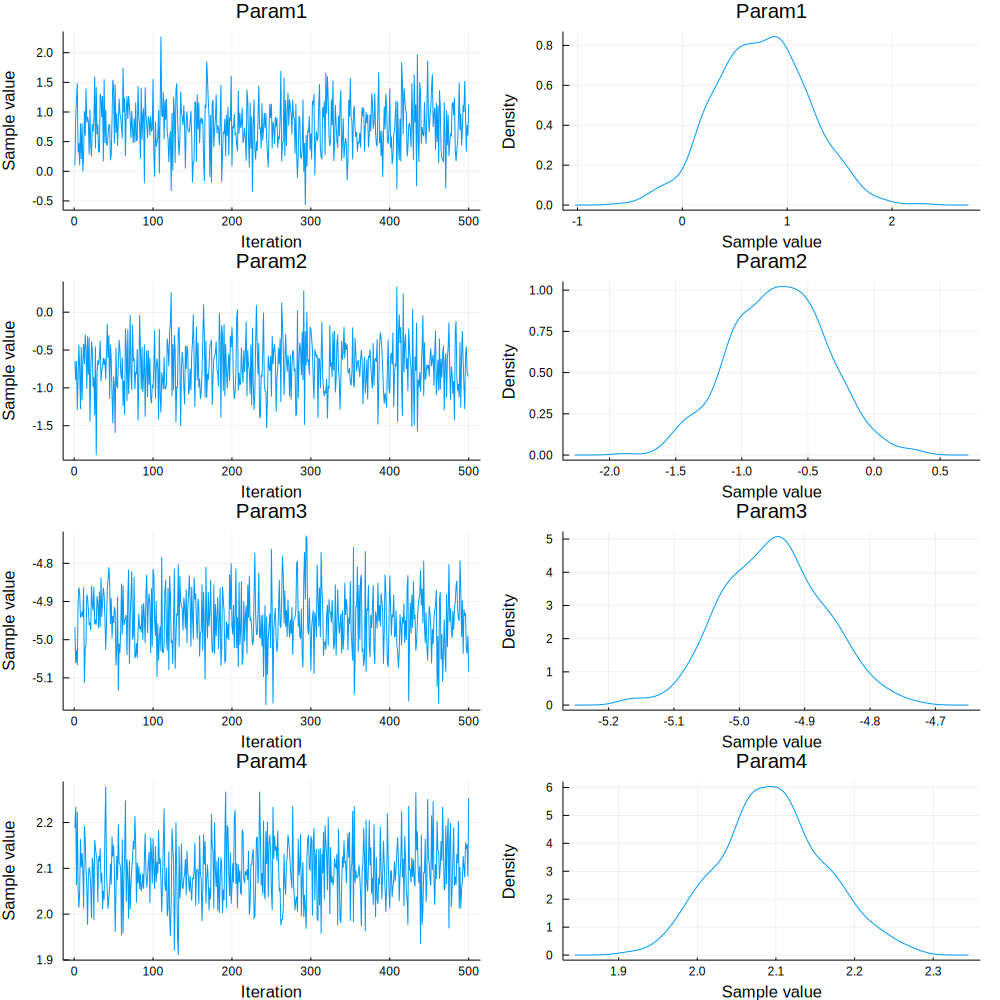

In [18]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(γ_sam[1, 1, :], γ_sam[1, 2, :], γ_sam[2, 1, :], γ_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

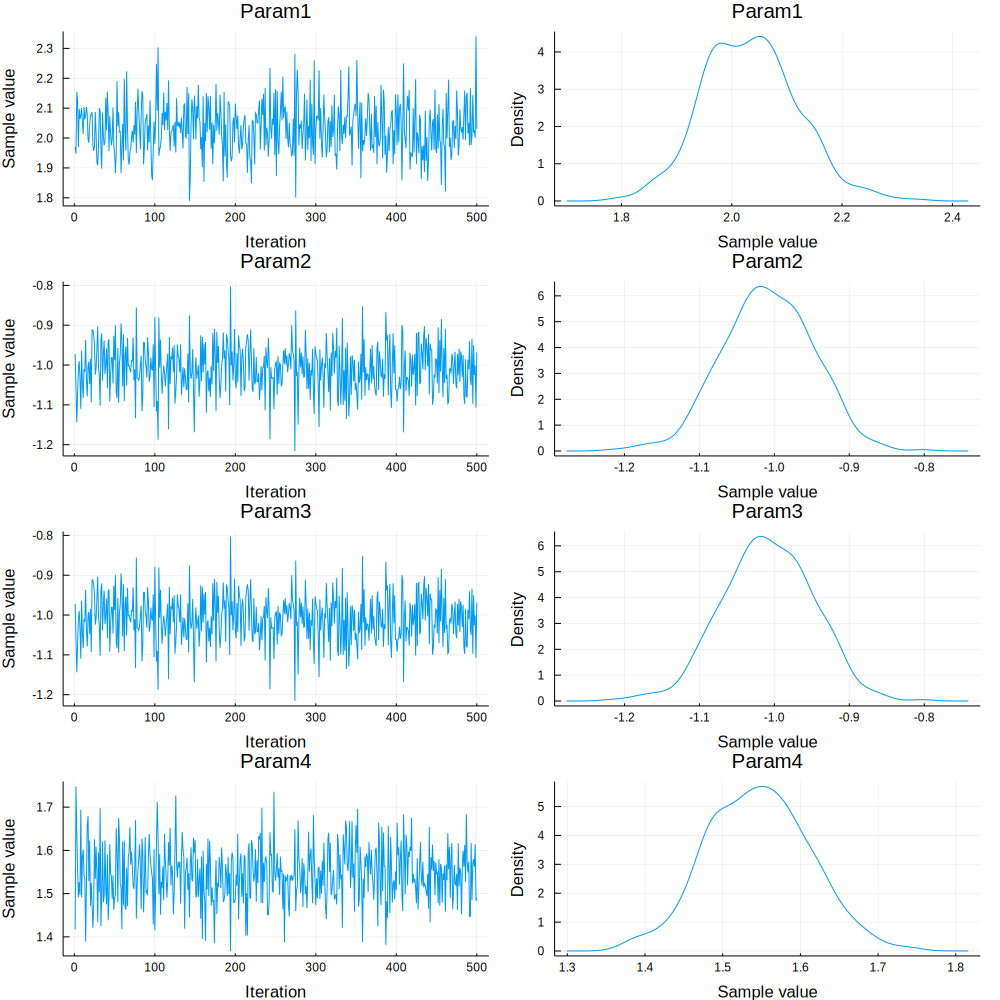

In [19]:
truncindex = 1; #Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

In [20]:
Σ

2×2 Array{Float64,2}:
  2.0  -1.0
 -1.0   1.5

# Posterior Inference 

In [21]:
N_Inf_burn = 1;
Y_M_pos_qt = Array{Float64, 3}(undef, nm, q, 3);
Y_M_pos_mean = Array{Float64, 2}(undef, nm, q);
for j in 1:q
    for i in 1:nm
        Y_M_pos_qt[i, j, :] = quantile(Y_M_sam[i, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        Y_M_pos_mean[i, j] = mean(Y_M_sam[i, j, N_Inf_burn:N_sam])
    end
end
# count the covarage of 95% CI #
count_Y_M = fill(0.0, 2);
for j in 1:q
    for i in 1:nm
        count_Y_M[j] = count_Y_M[j] + 
        ((Y_M_pos_qt[i, j, 1] < Y_ord[M[i], j]) && 
            (Y_M_pos_qt[i, j, 3] > Y_ord[M[i], j]))
    end
end
count_Y_M

2-element Array{Float64,1}:
 190.0
 189.0

In [22]:
count_Y_M ./ nm

2-element Array{Float64,1}:
 0.95 
 0.945

In [23]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[M, :] - Y_M_pos_mean).^2)
RMSPE = sqrt(MSPE); RMSPE

0.6712738029253661

In [24]:
N_Inf_burn = 1;
ω_pos_qt = Array{Float64, 3}(undef, n, q, 3);
ω_pos_mean = Array{Float64, 2}(undef, n, q);
for j in 1:q
    for i in 1:n
        ω_pos_qt[i, j, :] = quantile(γ_sam[i + p, j, N_Inf_burn:N_sam], [0.025, 0.5, 0.975]);
        ω_pos_mean[i, j] = mean(γ_sam[i + p, j, N_Inf_burn:N_sam])
    end
end
# count the covarage of 95% CI #
count_ω = fill(0.0, 2);
for j in 1:q
    for i in 1:n
        count_ω[j] = count_ω[j] + 
        ((ω_pos_qt[i, j, 1] < ω_ord[S[i], j]) && 
            (ω_pos_qt[i, j, 3] > ω_ord[S[i], j]))
    end
end
count_ω

2-element Array{Float64,1}:
 992.0
 972.0

In [25]:
count_ω ./ n

2-element Array{Float64,1}:
 0.992
 0.972

In [26]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, Integer(p * q + q * (q + 1) / 2), 5);
summary_table[1, :] = vcat(β[1, 1], mean(γ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(γ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(β[1, 2], mean(γ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(γ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(β[2, 1], mean(γ_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(γ_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(β[2, 2], mean(γ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(γ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat((1 / α - 1.0)* Σ[1, 1], mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat((1 / α - 1.0) * Σ[2, 2], mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat(Σ[1, 2] / (sqrt(Σ[1, 1] * Σ[2, 2])), 
    mean(Σ_sam[1, 2, N_Inf_burn:N_sam] ./ sqrt.(Σ_sam[1, 1, N_Inf_burn:N_sam] .* Σ_sam[2, 2, N_Inf_burn:N_sam])),
    quantile(Σ_sam[1, 2, N_Inf_burn:N_sam] ./ sqrt.(Σ_sam[1, 1, N_Inf_burn:N_sam] .* 
            Σ_sam[2, 2, N_Inf_burn:N_sam]), [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 3);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[2, 2]", "corr(Y1, Y2)"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "true" "mean" "median" "2.5%" "97.5%"], markdown)

|                  |   true |   mean | median |   2.5% |  97.5% |
|------------------|--------|--------|--------|--------|--------|
|          β[1, 1] |    1.0 |  0.757 |  0.754 | -0.102 |    1.6 |
|          β[1, 2] |   -1.0 | -0.722 | -0.722 |  -1.44 | -0.017 |
|          β[2, 1] |   -5.0 | -4.948 | -4.947 | -5.091 | -4.797 |
|          β[2, 2] |    2.0 |  2.095 |  2.095 |  1.974 |  2.234 |
| (1/α - 1)Σ[1, 1] |  0.222 |  0.239 |  0.238 |  0.219 |   0.26 |
| (1/α - 1)Σ[2, 2] |  0.167 |  0.181 |  0.181 |  0.166 |  0.197 |
|     corr(Y1, Y2) | -0.577 | -0.569 | -0.569 | -0.609 | -0.525 |


In [27]:
using JLD2

@save "../results/ω_pos_mean_conj_NNGP.jld" ω_pos_mean